In [1]:
import keras
import numpy as np
from keras import backend as K
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Input, Lambda, Layer
from keras.regularizers import l2
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import model_from_yaml
from modAL.models import ActiveLearner
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.python.keras.backend import eager_learning_phase_scope
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from keras import metrics

In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [4]:
img_rows, img_cols, img_chns = 32, 32, 3

In [5]:
# data load
(x_tr, y_tr), (x_te, y_te) = cifar10.load_data()
x_tr, x_te = x_tr.astype('float32')/255., x_te.astype('float32')/255.
# x_tr, x_te = x_tr.reshape(x_tr.shape[0], -1), x_te.reshape(x_te.shape[0], -1)
# print(x_tr.shape, x_te.shape)

In [6]:
# if K.image_data_format() == 'channels_first':
#     original_img_size = (img_chns, img_rows, img_cols)
# else:
original_img_size = (img_rows, img_cols, img_chns)

In [7]:
x_tr = x_tr.reshape((x_tr.shape[0],) + original_img_size)
x_te = x_te.reshape((x_te.shape[0],) + original_img_size)

In [8]:
BATCH_SIZE = 128
ORIGINAL_DIM = 784
HIDDEN_DIM = 512
EPOCH = 50
epsilon_std = 1.0
LATENT_DIMS = [64]
latent_dim = 256
intermediate_dim = 1024

# Encoder
x = Input(shape=original_img_size)
conv_1 = Conv2D(img_chns,
                kernel_size=(5, 5),
                padding='same', activation='relu')(x)
conv_2 = Conv2D(filters,
                kernel_size=(5, 5),
                padding='same', activation='relu',
                strides=(2, 2))(conv_1)

flat = Flatten()(conv_2)
hidden = Dense(intermediate_dim, activation='relu')(flat)

# mean and variance for latent variables
z_mean = Dense(latent_dim)(hidden)
z_log_var = Dense(latent_dim)(hidden)

In [9]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon

In [10]:
encoder_inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(1024, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
# encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
# encoder.summary()

In [11]:
# latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(1024, activation="relu")(z)
x = layers.Dense(8 * 8 * 64, activation="relu")(x)
x = layers.Reshape((8, 8, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
# decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
# decoder.summary()

In [12]:
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean_squash):
        x = K.flatten(x)
        x_decoded_mean_squash = K.flatten(x_decoded_mean_squash)
        xent_loss = img_rows * img_cols * metrics.binary_crossentropy(x, x_decoded_mean_squash)
        kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean_squash = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean_squash)
        self.add_loss(loss, inputs=inputs)
        return x

y = CustomVariationalLayer()([encoder_inputs, decoder_outputs])

In [13]:
vae = Model(encoder_inputs, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

# training
history = vae.fit(x_tr,
        shuffle=True,
        epochs=EPOCH,
        batch_size=BATCH_SIZE,
        validation_data=(x_te, None))



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 32)   896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 8, 8, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 4096)         0           ['conv2d_1[0][0]']               
                                                                                              

c:\users\pinar\onedrive\masaüstü\masterthesis\msthesisenv\lib\site-packages\keras\engine\training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


50000/50000 [==============================] - 85s 2ms/sample - loss: 666.0840 - val_loss: 634.1532
Epoch 2/50
50000/50000 [==============================] - 87s 2ms/sample - loss: 630.9145 - val_loss: 621.4265
Epoch 3/50
50000/50000 [==============================] - 88s 2ms/sample - loss: 618.6061 - val_loss: 613.1021
Epoch 4/50
50000/50000 [==============================] - 92s 2ms/sample - loss: 612.0317 - val_loss: 610.8090
Epoch 5/50
50000/50000 [==============================] - 87s 2ms/sample - loss: 608.3440 - val_loss: 609.6253
Epoch 6/50
50000/50000 [==============================] - 86s 2ms/sample - loss: 604.8524 - val_loss: 607.2203
Epoch 7/50
50000/50000 [==============================] - 86s 2ms/sample - loss: 602.9363 - val_loss: 602.2170
Epoch 8/50
50000/50000 [==============================] - 86s 2ms/sample - loss: 601.0188 - val_loss: 600.9666
Epoch 9/50
50000/50000 [==============================] - 86s 2ms/sample - loss: 599.4122 - val_loss: 601.1887
Epoch 10/50


In [14]:
# encoder from learned model
encoder = Model(encoder_inputs, z_mean)
decoder = Model(encoder_inputs, decoder_outputs)

In [15]:
X_train_enhanced = encoder.predict(x_tr, batch_size=128)

X_test_enhanced = encoder.predict(x_te, batch_size=128)

c:\users\pinar\onedrive\masaüstü\masterthesis\msthesisenv\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [16]:
np.save('x_train_enhanced_vanillavae.npy', X_train_enhanced)
np.save('x_test_enhanced_vanillavae.npy', X_test_enhanced)

In [17]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, random_state=0, learning_rate=70, perplexity=50, n_iter=2000, n_iter_without_progress=400, verbose=1)
EX2D = tsne.fit_transform(X_train_enhanced)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 50000 samples in 0.014s...
[t-SNE] Computed neighbors for 50000 samples in 69.814s...
[t-SNE] Computed conditional probabilities for sample 1000 / 50000
[t-SNE] Computed conditional probabilities for sample 2000 / 50000
[t-SNE] Computed conditional probabilities for sample 3000 / 50000
[t-SNE] Computed conditional probabilities for sample 4000 / 50000
[t-SNE] Computed conditional probabilities for sample 5000 / 50000
[t-SNE] Computed conditional probabilities for sample 6000 / 50000
[t-SNE] Computed conditional probabilities for sample 7000 / 50000
[t-SNE] Computed conditional probabilities for sample 8000 / 50000
[t-SNE] Computed conditional probabilities for sample 9000 / 50000
[t-SNE] Computed conditional probabilities for sample 10000 / 50000
[t-SNE] Computed conditional probabilities for sample 11000 / 50000
[t-SNE] Computed conditional probabilities for sample 12000 / 50000
[t-SNE] Computed conditional probabilities for s

In [18]:
y_tr = y_tr.reshape((y_tr.shape[0],))

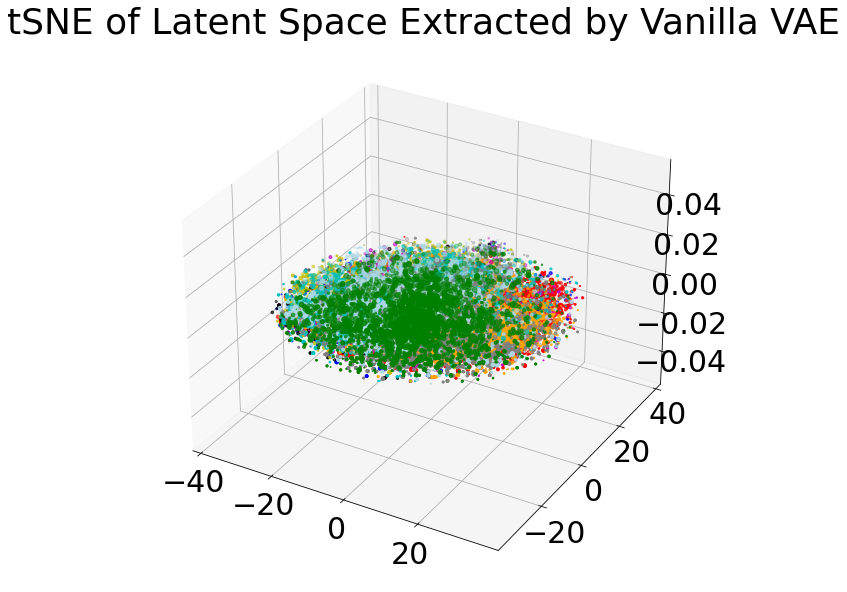

In [21]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(projection='3d')
plt.title("tSNE of Latent Space Extracted by Vanilla VAE")
plt.rcParams.update({'font.size': 30})
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'lightblue', 'orange', 'gray']

for i, c in zip(list(range(0, 10)), colors):
    idx = y_tr==i
    plt.scatter(EX2D[y_tr==i, 1], EX2D[y_tr==i,2], EX2D[y_tr==i,0], c=c, label=str(i))

In [ ]:
sampled_indices = [29, 32, 49987, 21, 49981, 51, 19, 11, 8, 49963]

In [ ]:
image_samples = x_tr[sampled_indices]
fig, ax = plt.subplots(1, 10, figsize=(15,5))
for i in range(10):
    ax[i].imshow(image_samples[i], cmap='gray')
    ax[i].axis('off')
plt.savefig(r"C:\Users\pinar\OneDrive\Masaüstü\masterthesis\figures\cifar10\g(e(x))\x.png")
plt.show()

In [ ]:
gener = decoder.predict(x_tr[sampled_indices]).reshape(10, 32, 32, 3)
fig, ax = plt.subplots(1, 10, figsize=(15,5))
for i in range(10):
    ax[i].imshow(gener[i], cmap='gray')
    ax[i].axis('off') 
plt.savefig(r"C:\Users\pinar\OneDrive\Masaüstü\masterthesis\figures\cifar10\g(e(x))\vanilla_vae_generator_output.png")
plt.show()